# Proteína CDK2

### Obtención de los ligandos ubicados en la cavidad de la proteína
Esta libreta tiene como objetivo obtener los ligandos cocristalizados en el sitio activo de la proteína CDK2, difereciando dichas moléculas de iones, moléculas del solvente, o residuo modeificados de la proteína. Y diferenciando también entre posibles inhibidores alostéricos de inhibidores competitivos.

## En resumen:
Se realizan los siguientes pasos:

1. Se identifican los residuos que forman parte del pocket de interés de la proteína (en este caso el sitio activo de la ERK2), tomando una estructura cristalográfica de referencia.
2. Se itera la lista de archivos pdb de la proteína evaluando todas las posibles moléculascon átomos con la etiqueta HETATM que puedan ser ligandos. Para ello:
     - Se evalúa que la molécula esté en la cavidad de interés de la proteína.
     - Se evalúa qeu la molécula tenga como mínimo un peso molecular para diferenciarla de iones o moléculas del solvente.
     - Se evalúa que la molécula no forme parte de la cadena protéica, es decir, que no sea un residuo no estándar de la proteína.
3. Si los criterios anteriores se cumplen, se guarda la molécula en nuevo archivo pdb.

#### Importamos parte de las librerías a usar


In [1]:
from prody import *
import numpy as np
import csv
import pandas as pd
import sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

In [2]:
# Nombre de la proteina de interés
prot_name = 'cdk2'

#### Carga del dataframe con la información de la proteína

In [3]:
# abrir la tabla de metadatos de las proteinas
import glob, os
# Directorio hacia el archivo csv
path_df_csv = glob.glob(os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys.json'))
df_prot = pd.read_json(path_df_csv[0])
df_prot.set_index('PDB_ID', inplace=True)
df_prot.tail(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
6q4i,cdk2 in complex with fraglite35,2019-03-20,1,A,1.11,297,96.644295,2,"[8, 4]","[[38, 45], [153, 156]]",2,"[DMS, HGK]"
6q4j,cdk2 in complex with fraglite34,2019-03-20,1,A,1.05,298,96.979866,2,"[9, 3]","[[39, 47], [155, 157]]",2,"[DMS, HHB]"
6q4k,cdk2 in complex with fraglite38,2019-03-20,1,A,1.06,298,97.651007,2,"[8, 2]","[[39, 46], [125, 126]]",2,"[EDO, HHW]"


In [5]:
df_prot.shape

(402, 12)

### Conteo de estructuras con ligandos
Preguntamos cuántas y cuales estructuras cristalográficas tienen ligandos y creamos una nueva tabla con ellas (df_prot_ligs).

In [6]:
df_prot_ligs = df_prot[df_prot.NumLigs > 0]
print(F'{len(df_prot_ligs)} de {len(df_prot)} cristales con al menos un ligando.')

395 de 402 cristales con al menos un ligando.


### Nota:
> **No todas estas moléculas son ligandos de la proteína**, ya que sólo hemos identificado cadenas en el archivo pdb con la designación HETATM; pudiendo ser iones, residuos no éstandar (con modificaciones postraduccionales) o moléculas del cosolvente usado durante obtención de la estructura.
Por lo tanto, si es ligando o no lo determinamos más adelante.

### ¿Cuántos ligandos diferentes hay?
Ahora preguntamos cuántas moléculas distintas han sido co-cristalizadas con la proteína.

In [7]:
# ¿Cuantos ligandos hay en total?
import itertools
# Lista de nombre de todos los ligandos
lig_full_list = list( itertools.chain.from_iterable( df_prot.NameLigs ) )
print(F'En total hay {len(lig_full_list)} moléculas HETATM,')

lig_all_list = list(set(lig_full_list))
print(F'de las cuales {len(lig_all_list)} son moléculas DISTINTAS.')

En total hay 759 moléculas HETATM,
de las cuales 365 son moléculas DISTINTAS.


## Moléculas en la cavidad catalítica
Ahora procedemos a identificar qué moléculas se encuentran en el sitio activo de la proteína, y si éstas tienen un peso molecular suficcientemente grande como para ser diferenciadas de posibles moléculas del solvente.

In [8]:
from modules.subsecuencias_cdk2 import get_pocket_residues
pocket_residues = get_pocket_residues('str')
print(len(get_pocket_residues('list')), "residuos corresponden a los que definen al pocket de la proteína CDK2.")
print(pocket_residues)

40 residuos corresponden a los que definen al pocket de la proteína CDK2.
8 9 10 11 12 13 14 15 16 17 18 19 30 31 32 33 64 65 79 80 81 82 83 84 85 86 87 88 89 90 129 130 131 132 133 134 143 144 145 146


### Carga de una estructura de referencia

In [9]:
# Estructura de referencia con hidrógenos, la obtenemos del ensamble
pdbs_model_dir = "../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/PREP_ALL_ENSAMBLE/"
ref_id = '1fin'
pdb_file_tail = "_ENS.pdb"
# Cargamos el archivo de referencia
ref_structure = parsePDB(pdbs_model_dir + ref_id + pdb_file_tail)
ref_structure.setChids("A")

@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


### Visualización del sitio activo

In [10]:
# Cálculo del centro total de la proteína de referencia
centro_strc_total = calcCenter(ref_structure).round(3)
# Definimos los átomos del pocket
pocket = ref_structure.select("ca resnum " + pocket_residues)
centro_pocket = calcCenter(pocket)
print("Centro de la estructura completa:", centro_strc_total)
print("Centro de los Ca del sitio activo:", centro_pocket)

Centro de la estructura completa: [-20.114 214.997 119.258]
Centro de los Ca del sitio activo: [-12.5263   206.416975 113.78675 ]


Seleccionamos todos los átomos de los residuos en selected_residues

In [11]:
# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = ref_structure.select(F'resnum {pocket_residues}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

Incluimos en la visualización el ligando de la estructura de referencia:

In [13]:
# Cargamos el ligando correspondiente.
import nglview as nv
pdbs_raw_ligs_file = "../../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW/1fin_lig.pdb"
ref_lig_ATP = nv.FileStructure(pdbs_raw_ligs_file)

_ColormakerRegistry()

Visualizamos:

In [60]:
view = nv.show_prody(ref_structure)
view.clear_representations()
view.add_representation('cartoon', selection='protein', color='white')
view.add_licorice(selection = pocket_atoms_index, color='cyan')
view.add_cartoon(selection = pocket_atoms_index, color='cyan')
# Incluimos al ligando
view.add_structure(ref_lig_ATP)
view

NGLWidget()

In [61]:
view.render_image()

Image(value=b'', width='99%')

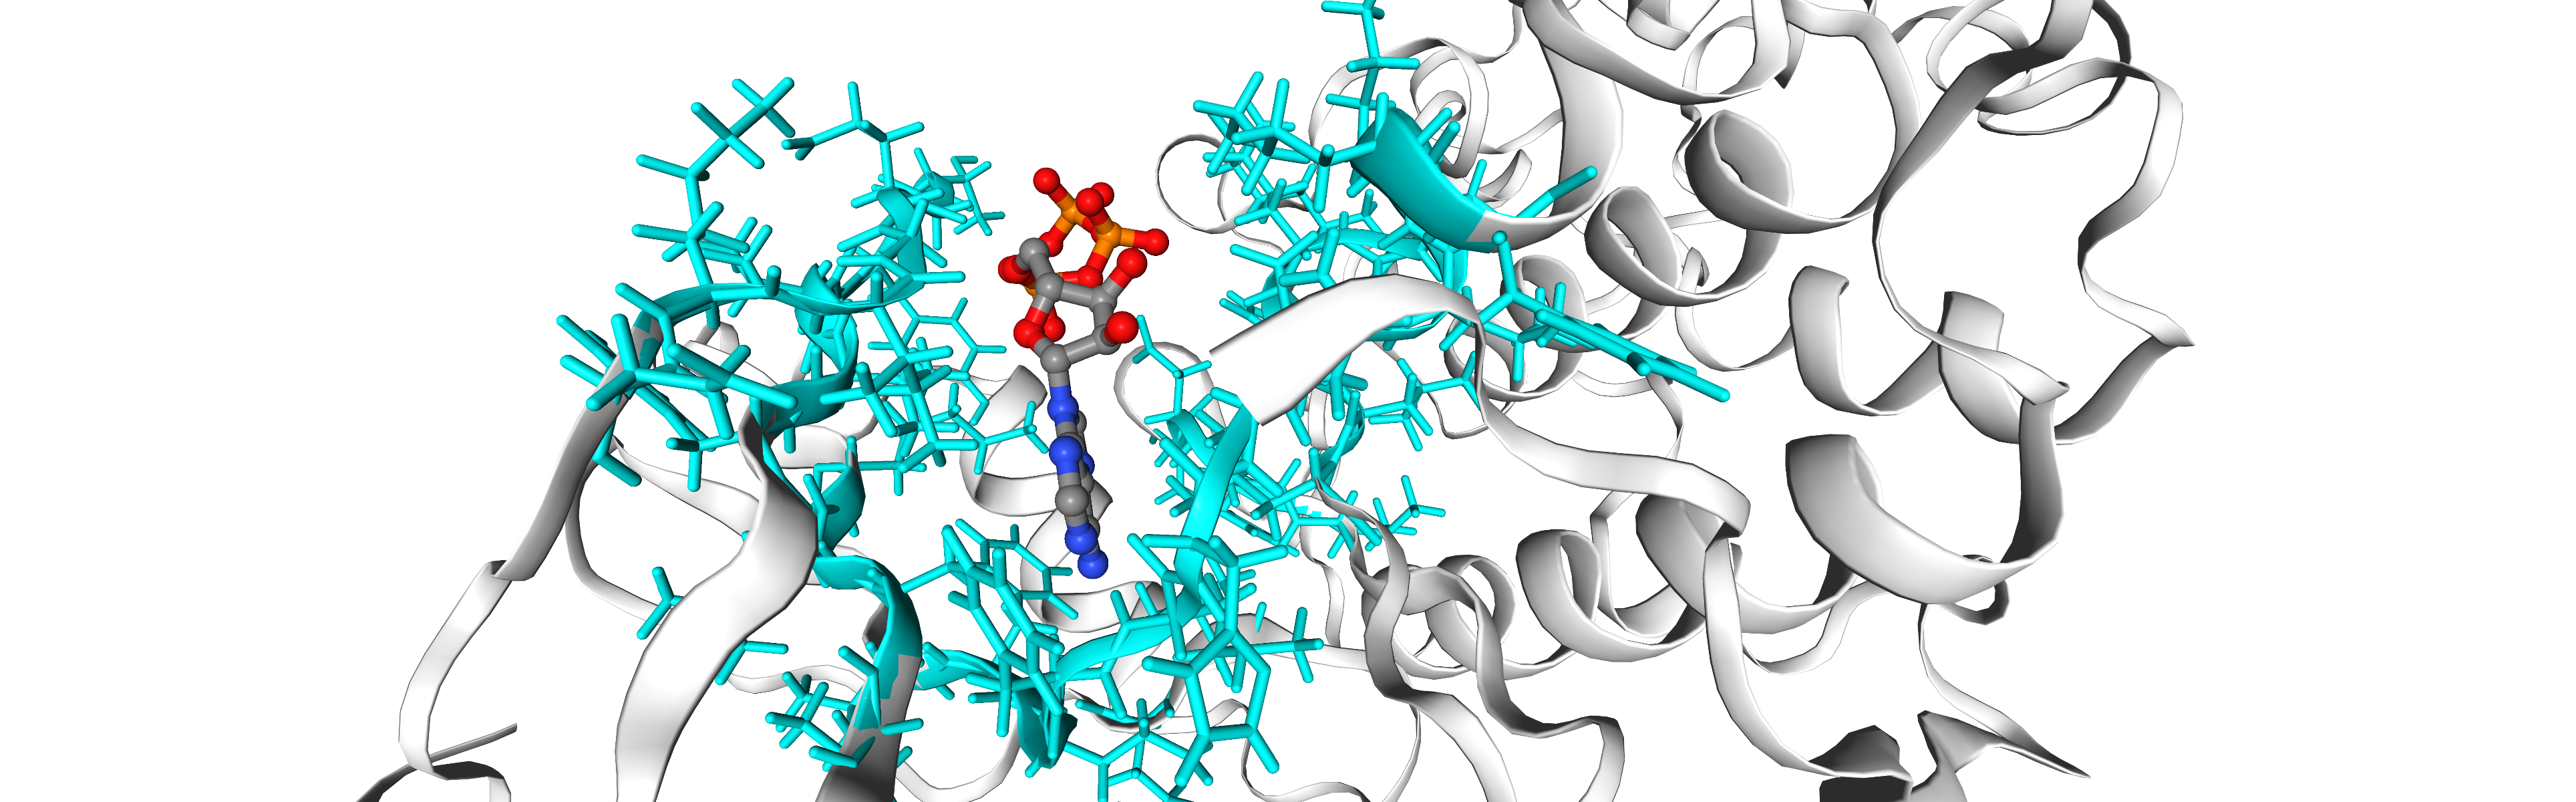

In [62]:
view._display_image()

Cualquier molécula que tenga un átomo en contacto con la esfera, será considerada como ligando unido al sitio activo.

## Determinación de los ligandos
Ahora, procedemos a utilizar la estructura de referencia modelada con Modeller. Hay que recordar que todas las estructuras modeladas fueron alineadas previamente tomando en cuenta la estructura secundaria de la proteína, y que el alineamiento incluyó la reposición relativa de los ligandos.


### Pasos y función para obtener los ligandos

In [14]:
# Definimos los directorios de trabajo
RAW_LIG_DIR = F'../../ARCHIVOS/CRISTALES/LIGS_{prot_name.upper()}/RAW/'
PROT_CHAINS_DIR = F'../../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_PREPARADAS/PREP_ALL_ENSAMBLE/'

# Directorio de salida (lo creamos si no existe):
PK_LIGS_DIR = F'../../ARCHIVOS/CRISTALES/LIGS_{prot_name.upper()}/POCKET_LIGS/'
import os
if not os.path.exists(PK_LIGS_DIR):
    os.makedirs(PK_LIGS_DIR)

In [15]:
def get_pocket_ligand(pdb_id,
                       pocket_residues = pocket_residues,
                       cutoff = 3,
                       raw_lig_dir = RAW_LIG_DIR,
                       prot_chain_dir = PROT_CHAINS_DIR,
                       pk_ligs_dir = PK_LIGS_DIR,
                       min_weight = 97, # mw de sulfato  + 1
                       write_files = True):
    # 1) Se carga cargan las moléculas HETATM usando Prody
    try:
        lig = parsePDB(raw_lig_dir + pdb_id  + "_lig.pdb")
    except Exception as e:
        print("La proteina", pdb_id, "NO TIENE LIGANDO.")
        return(None, None)
    # 2) Se carga la proteína y se seleccionan los residuos que definen el pocket
    protein = parsePDB( prot_chain_dir + pdb_id + "_ENS.pdb" )
    protein_pocket = protein.select("resid " + pocket_residues)
    
    # Se seleccionan los ligandos (RESIDUOS no protéicos) que estén a no más de cutoff A
    # de cualquier átomo de los residuos del pocket de la proteína
    lig_sel = lig.select('within ' + str(cutoff) + ' of inhibitor', inhibitor = protein_pocket)
    if lig_sel is None:
        print("La proteina", pdb_id, "no tiene ligando en el pocket.")
        return(None, None)
    
    # Se obtine la lista de moléculas que cumplen el criterio anterior
    inhibidor_list = np.unique( lig_sel.getResnums() )
    print( inhibidor_list )
    
    # Calcula el centro geométrico del pocket de la proteína
    prot_pocket_center = calcCenter(protein_pocket)
    
    # Puede que haya más de una molécula en el pocket 
    # (debido a presencia de iones, cosolvente o residuos modificados)
    # Se itera entre cada molecula del ligando, se calcula su masa y se mantiene el ligando con mayor masa 
    heavier_lig_mass = 0
    true_lig = ""

    for i in inhibidor_list:
            mol = lig.select("resnum " + str(i))
            mass = mol.getMasses().sum()
            # Se considera ligando sólo si su masa es igual o mayor a la de una molécula de sulfato
            if mass < min_weight:
                continue
            # Si las masas de dos moléculas son iguales, decide entre la molécula más cerana
            if mass == heavier_lig_mass :
                dist_prot_m1 = calcDistance(prot_pocket_center, calcCenter(mol))
                dist_prot_m2 = calcDistance(prot_pocket_center, calcCenter(true_lig))
                if dist_prot_m1 < dist_prot_m2:
                    heavier_lig_mass, true_lig = mass, mol
                    continue
            # Si el ligando i es más pesado que i - 1, se actualizan los datos
            heavier_lig_mass, true_lig = (mass, mol) if mass > heavier_lig_mass else (heavier_lig_mass, true_lig)
            
    # Se guarda el ligando sólo si su masa es igual o mayor a la de un sulfato
    # si el ligando aparece 2 veces cerca del pocket, se elige la molécula más cercana al centro
    if true_lig != "": # Si el ligando existe y su masa fue mayor 96
        # Se extrae el nombre del ligando
        name_lig = np.unique( true_lig.getResnames() )[0]

        # Se combinan proteína y ligando en un solo objeto AtomGroup, de tal manera que
        # sea posible superponer las estructuras de la proteína de acuerdo a los residuos de su pocket
        # y esto afcete la psoición del ligando
        complejo_PL = protein + true_lig.toAtomGroup()
        if write_files:
            # Se guardan ligando y proteína alineados según la estructura de referencia
            print(F'Proteína {pdb_id}: ligando {name_lig} guardado.')
            writePDB( pk_ligs_dir + "/" + pdb_id + "_" + name_lig + "_LIG.pdb", 
                      complejo_PL.select("resname " + name_lig) )
        return(name_lig, heavier_lig_mass)
    else: 
        print(F"La proteina {pdb_id} NO TIENE LIGANDO.")
        return(None, None)

## Obtenemos los ligandos y actualizamos el dataframe
Finalmente se obtienen los ligandos y a la tabla de datos se le agrega la información sobre el inhibidor y su masa

In [49]:
# Se agregan dos columnas al dataframe
df_prot["Inhib"] = ""
df_prot["Inhib_mass"] = np.nan

# Se obtienen los ligandos
for pdb_id in df_prot.index[:5]:
    print('Procesando:', pdb_id)
    inhibidor = get_pocket_ligand(pdb_id, write_files = False, cutoff = 3, min_weight = 80)
    df_prot.at[str(pdb_id), 'Inhib'] = inhibidor[0]
    df_prot.at[pdb_id, 'Inhib_mass'] = inhibidor[1]

@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.


Procesando: 1aq1
[299]
Procesando: 1b38
[381 382]
Procesando: 1b39


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[381 382]
Procesando: 1buh
La proteina 1buh NO TIENE LIGANDO.
Procesando: 1ckp
[299 300]


### DataFrame actualizado
Como resultado las moléculas fueron guardadas con el id del **PDB** correspondiente y el nombre de la molécula. Además el DataFrame inicial ahora tendrá dos columnas más:
1. **Inhib:** Con el nombre de la molécula hayada en el sitio activo (código del PDB), si la hubo.
2. **Inhib_mass**: Con la masa del ligando.
    
Por último guardamos dicho DataFrame:

In [48]:
n_confs = df_prot.shape[0]
df_prot.to_json(F'../data/TABLA_MTDATA_{prot_name.upper()}_{n_confs}_crys_LIGS_INFO.json')

In [46]:
# número de moléculas encontradas:
# df_prot.Inhib.notnull().sum()